In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Feature extraction
from sklearn.feature_selection import VarianceThreshold

from boruta import BorutaPy
from sklearn.inspection import permutation_importance

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

# Classification models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [2]:
data_path = "../../data/"

In [3]:
df_radiomics = pd.read_excel(data_path + 'quantitative_radiomic_features.xls')
df_radiomics['Lesion Name'] = df_radiomics['Lesion Name'].str.replace(r'-1\.les|-S2-1\.les', '', regex=True)

df_clinical = pd.read_excel(data_path + "clinical_data.xls")
df_clinical.replace("[Not Available]", np.nan, inplace=True)
df_clinical.rename(columns={'bcr_patient_barcode': 'Lesion Name'}, inplace=True)
df_clinical = df_clinical[['Lesion Name', 'age_at_initial_pathologic_diagnosis', 'ajcc_neoplasm_disease_stage', "ajcc_tumor_stage_code", "number_of_lymphnodes_positive_by_he",
                          "breast_carcinoma_estrogen_receptor_status", "breast_carcinoma_progesterone_receptor_status"]]

target_class = pd.read_csv(data_path + 'target_class.csv')
target_class.rename(columns={'CLID': 'Lesion Name'}, inplace=True)

/tmp/ipykernel_1199/3106461490.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clinical.replace("[Not Available]", np.nan, inplace=True)


In [4]:
df = pd.merge(df_radiomics, target_class, on='Lesion Name', how='inner')
df = pd.merge(df, df_clinical, on='Lesion Name', how='inner')
df = df.drop(columns=df.columns[0])
df

Maximum enhancement (K1)  Time to peak (K2)  Uptake rate (K3)  \
0                   1.602573            145.433          0.011019   
1                   4.072152            144.752          0.028132   
2                   1.303264            168.383          0.007740   
3                   0.758630             60.000          0.012644   
4                   3.353556             60.000          0.055893   
..                       ...                ...               ...   
71                  1.277688             60.000          0.021295   
72                  1.495674             60.000          0.024928   
73                  2.182750             60.000          0.036379   
74                  1.354828            192.786          0.007028   
75                  1.825341            201.786          0.009046   

    Washout rate (K4)  Curve shape index (K5)   E1 (K6)  \
0            0.000809               -0.099998  1.550204   
1            0.001510               -0.007311  3.973258   
2            0.000667               -0.146959  1.273733   
3            0.000479               -0.150482  0.758630   
4            0.000920               -0.080066  3.353556   
..                ...                     ...       ...   
71           0.000611               -0.149392  1.277688   
72           0.000093               -0.017541  1.495674   
73           0.001081               -0.125678  2.182750   
74           0.000067                0.043301  1.290058   
75           0.001355               -0.057510  1.732952   

    Signal Enhancement Ratio (SER) (K7)  Maximum enhancement-variance (E1)  \
0                              1.111109                           0.125963   
1                              1.007365                           4.054312   
2                              1.172277                           0.534411   
3                              1.177138                           0.037956   
4                              1.087034                           2.330160   
..                                  ...                                ...   
71                             1.175629                           0.271695   
72                             1.017854                           0.123041   
73                             1.143744                           0.225339   
74                             0.958496                           0.108778   
75                             1.061019                          10.346100   

    Enhancement-Variance Time to Peak (E2)  \
0                                   60.000   
1                                  229.504   
2                                   60.000   
3                                  298.418   
4                                   60.000   
..                                     ...   
71                                  60.000   
72                                  60.000   
73                                 313.733   
74                                  60.000   
75                                 343.572   

    Enhancement-variance Increasing Rate (E3)  ...  \
0                                    0.002099  ...   
1                                    0.017666  ...   
2                                    0.008907  ...   
3                                    0.000127  ...   
4                                    0.038836  ...   
..                                        ...  ...   
71                                   0.004528  ...   
72                                   0.002051  ...   
73                                   0.000718  ...   
74                                   0.001813  ...   
75                                   0.030113  ...   

    Surface Area to Volume ratio (G3)  Volume of most enhancing voxels (S4)  \
0                            0.922937                              22.15705   
1                            0.849641                             111.70860   
2                            0.842762                             236.23630   
3          

In [5]:
from sklearn.preprocessing import StandardScaler

radiomic_features = df.drop(columns=["Pam50.Call", 'age_at_initial_pathologic_diagnosis', 'ajcc_neoplasm_disease_stage', "ajcc_tumor_stage_code", "number_of_lymphnodes_positive_by_he",
                                    "breast_carcinoma_estrogen_receptor_status", "breast_carcinoma_progesterone_receptor_status"])

scaler = StandardScaler()
scaled_features = scaler.fit_transform(radiomic_features)

df_scaled = pd.DataFrame(scaled_features, columns=radiomic_features.columns)

df_scaled["Pam50.Call"] = df["Pam50.Call"].values
df_scaled["age_at_initial_pathologic_diagnosis"] = df["age_at_initial_pathologic_diagnosis"].values
df_scaled["ajcc_neoplasm_disease_stage"] = df["ajcc_neoplasm_disease_stage"].values
df_scaled["ajcc_tumor_stage_code"] = df["ajcc_tumor_stage_code"].values
df_scaled["number_of_lymphnodes_positive_by_he"] = df["number_of_lymphnodes_positive_by_he"].values 
df_scaled["breast_carcinoma_estrogen_receptor_status"] = df["breast_carcinoma_estrogen_receptor_status"].values
df_scaled["breast_carcinoma_progesterone_receptor_status"] = df["breast_carcinoma_progesterone_receptor_status"].values 

df = df_scaled
df_dummies = pd.get_dummies(df, columns=['ajcc_neoplasm_disease_stage', "ajcc_tumor_stage_code",
                                        "breast_carcinoma_estrogen_receptor_status", 
                                         "breast_carcinoma_progesterone_receptor_status"], drop_first=True)

new_dummy_columns = set(df_dummies.columns) - set(df.columns)

df = df_dummies

In [6]:
df

Maximum enhancement (K1)  Time to peak (K2)  Uptake rate (K3)  \
0                  -0.195663           0.011278         -0.496149   
1                   2.618630           0.003479          0.917726   
2                  -0.536750           0.274115         -0.767103   
3                  -1.157407          -0.967149         -0.361928   
4                   1.799730          -0.967149          3.211365   
..                       ...                ...               ...   
71                 -0.565896          -0.967149          0.352830   
72                 -0.317483          -0.967149          0.653004   
73                  0.465498          -0.967149          1.599129   
74                 -0.477989           0.553592         -0.825950   
75                  0.058200           0.656665         -0.659195   

    Washout rate (K4)  Curve shape index (K5)   E1 (K6)  \
0           -0.151982               -0.297797 -0.155749   
1            0.397861                0.255429  2.655287   
2           -0.263946               -0.578093 -0.476489   
3           -0.411282               -0.599120 -1.074071   
4           -0.065331               -0.178825  1.936358   
..                ...                     ...       ...   
71          -0.307554               -0.592611 -0.471901   
72          -0.714435                0.194371 -0.219010   
73           0.061532               -0.451073  0.578081   
74          -0.734472                0.557517 -0.457550   
75           0.276111               -0.044192  0.056261   

    Signal Enhancement Ratio (SER) (K7)  Maximum enhancement-variance (E1)  \
0                              0.009570                          -0.130554   
1                             -0.257523                          -0.074160   
2                              0.167049                          -0.124690   
3                              0.179564                          -0.131817   
4                             -0.052412                          -0.098911   
..                                  ...                                ...   
71                             0.175679                          -0.128462   
72                            -0.230518                          -0.130596   
73                             0.093590                          -0.129127   
74                            -0.383337                          -0.130801   
75                            -0.119389                           0.016163   

    Enhancement-Variance Time to Peak (E2)  \
0                                -1.065664   
1                                 0.222799   
2                                -1.065664   
3                                 0.746640   
4                                -1.065664   
..                                     ...   
71                               -1.065664   
72                               -1.065664   
73                                0.863055   
74                               -1.065664   
75                                1.089872   

    Enhancement-variance Increasing Rate (E3)  ...  \
0                                   -0.123696  ...   
1                                   -0.093276  ...   
2                                   -0.110393  ...   
3                                   -0.127551  ...   
4                                   -0.051902  ...   
..                                        ...  ...   
71                                  -0.118950  ...   
72                                  -0.123792  ...   
73                                  -0.126395  ...   
74                                  -0.124256  ...   
75                                  -0.068949  ...   

    ajcc_neoplasm_disease_stage_Stage IIA  \
0                                   False   
1                                   False   
2                                   False   
3                                    True   
4                                   False   
..                                    ...   
71          

In [7]:
features = df.columns.difference(['Pam50.Call'])
target_col = 'Pam50.Call'

X_train, X_test, y_train, y_test = train_test_split(
    df[features],
    df[target_col],
    test_size=0.2,
    random_state=42,
    stratify=df[target_col]
)

In [8]:
X_train

Contrast (T1)  Correlation (T2)  Curve shape index (K5)  \
11      -0.684527          0.679692               -0.349218   
70       1.180559         -1.166517               -0.231014   
44       0.425652         -0.410766               -0.190543   
36      -0.247246          0.327783               -0.586582   
22      -1.962088          1.926856               -0.609998   
16      -1.519470          1.495774                0.193791   
12       0.365084         -0.408202               -0.692573   
55      -1.416246          1.406506               -0.551006   
9        1.948630         -1.850265               -0.388592   
51      -1.266737          1.256714                0.680154   
38       0.000722          0.028911                1.279733   
41      -1.443959          1.456929               -4.224826   
3       -0.165973          0.154708               -0.599120   
18      -1.115510          1.134648                0.698946   
59       1.311407         -1.343411               -0.039172   
10       0.474278         -0.532981               -0.427666   
67       0.461316         -0.449025               -1.246098   
73       0.785688         -0.786756               -0.451073   
29      -0.495916          0.510535               -0.088319   
48       0.906580         -0.764116                1.141584   
61       0.742025         -0.597933               -0.152540   
74       1.272052         -1.446566                0.557517   
47      -1.190521          1.174064                1.362383   
20       0.230359         -0.270400               -0.084558   
60       0.023557         -0.003692                0.948896   
72       1.514138         -1.508673                0.194371   
37       0.243886         -0.225912                0.863181   
17      -0.936818          0.962410                0.229023   
64       0.638033         -0.675644               -0.896168   
27      -1.074455          1.038459                0.717620   
5        0.393740         -0.449952                0.362597   
33      -0.550107          0.569409                1.073366   
31      -0.625148          0.646606                1.131800   
63       0.991367         -1.078468               -0.201772   
35      -1.389738          1.343071               -1.133912   
56       0.479911         -0.542449                0.142266   
21       0.664758         -0.532610                0.967605   
54      -0.993378          0.938207                0.362482   
53      -0.047926          0.053759               -0.058553   
49      -0.809791          0.822921                1.657512   
8       -0.500733          0.452560               -0.653082   
39      -2.600732          2.679125               -2.648674   
42       0.719131         -0.668821                0.408653   
15       0.693378         -0.739159                0.050185   
43      -1.544508          1.716621                1.406424   
13      -0.029702         -0.007221               -0.896213   
66       1.946665         -1.840858               -0.348256   
68       1.152910         -1.216108               -0.913665   
14      -1.157532          1.098153               -0.225168   
0        0.786074         -0.863957               -0.297797   
28       0.090064         -0.098434                0.886206   
58       1.504031         -1.591482                0.031615   
6        1.201751         -1.085072                2.498778   
23      -0.752604          0.737474                0.162778   
45      -0.232040          0.213789                0.341049   
25       1.280611         -1.101070                3.575984   
26       0.247191         -0.297543               -0.639681   
69       0.400674         -0.459388               -1.165688   
7       -0.590585          0.669185               -0.313742   
57       0.196208         -0.270156                0.493640   

    Difference Entropy (T3)  Difference Variance (T4)   E1 (K6)  \
11                -0.555099                 -0.695339  0.592338   
70                 1.07500

In [9]:
under_sampler = RandomUnderSampler(sampling_strategy={"LumA": 30}, random_state=42)
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)

over_sampler = SMOTE(sampling_strategy="not majority", random_state=42, k_neighbors=3)
X_train_resampled, y_train_resampled = over_sampler.fit_resample(X_train_under, y_train_under)

print("\nDistribución tras Under-Sampling + Over-Sampling en train:")
print(y_train_resampled.value_counts())


Distribución tras Under-Sampling + Over-Sampling en train:
Pam50.Call
Basal    30
Her2     30
LumA     30
LumB     30
Name: count, dtype: int64


In [10]:
df_resampled = pd.concat(
    [pd.DataFrame(X_train_resampled), pd.Series(y_train_resampled, name='Pam50.Call')],
    axis=1
)

In [11]:
df_train = df_resampled

In [12]:
selected_features = ['Margin Sharpness (M1)', 'Maximum enhancement-variance (E1)', 'Surface Area (S3)'] + list(new_dummy_columns)

In [13]:
X_train_resampled_selected = X_train_resampled[selected_features]
X_test_selected = X_test[selected_features]

In [14]:
def train_and_evaluate_model(X_train, X_test, y_train, y_test, features, target_col, model, imprimir=False):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    if imprimir:
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
    return macro_f1

In [15]:
rf_model = RandomForestClassifier(random_state=42)

macro_f1_score = train_and_evaluate_model(
    X_train_resampled_selected, X_test_selected, y_train_resampled, y_test,
    features=[col for col in df.columns if col != "Pam50.Call"],
    target_col="Pam50.Call",
    model=rf_model,
    imprimir=True
)

Classification Report:
              precision    recall  f1-score   support

       Basal       1.00      1.00      1.00         2
        Her2       1.00      1.00      1.00         1
        LumA       0.89      0.73      0.80        11
        LumB       0.25      0.50      0.33         2

    accuracy                           0.75        16
   macro avg       0.78      0.81      0.78        16
weighted avg       0.83      0.75      0.78        16



Classification Report:
              precision    recall  f1-score   support

       Basal       1.00      1.00      1.00         2
        Her2       1.00      1.00      1.00         1
        LumA       0.89      0.73      0.80        11
        LumB       0.25      0.50      0.33         2

    accuracy                           0.75        16
   macro avg       0.78      0.81      0.78        16
weighted avg       0.83      0.75      0.78        16



<Figure size 800x800 with 0 Axes>

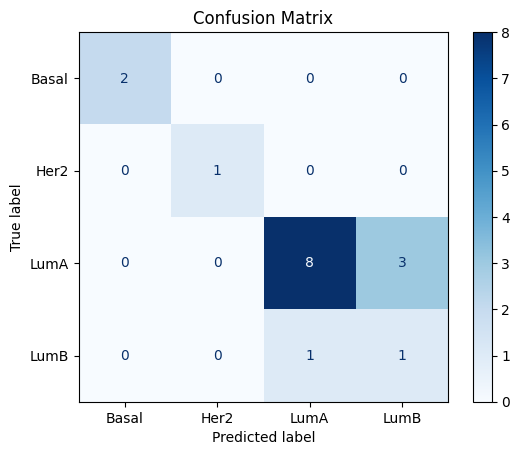

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def train_and_evaluate_model(X_train, X_test, y_train, y_test, features, target_col, model, imprimir=False):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    
    if imprimir:
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        
        # Generar matriz de confusión
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
        
        # Mostrar matriz de confusión con gráfico
        plt.figure(figsize=(8, 8))
        disp.plot(cmap='Blues', values_format='d')
        plt.title("Confusion Matrix")
        plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')  # Línea opcional para guardar el plot
        plt.show()
    
    return macro_f1

# Entrenamiento y evaluación
rf_model = RandomForestClassifier(random_state=42)

macro_f1_score = train_and_evaluate_model(
    X_train_resampled_selected, X_test_selected, y_train_resampled, y_test,
    features=[col for col in df.columns if col != "Pam50.Call"],
    target_col="Pam50.Call",
    model=rf_model,
    imprimir=True
)